## Create COCO annotation files ##
This notebooks requires the detectron2 library.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import json
from pathlib import Path

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Detectron2 library
import detectron2
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.fileutils import FileOP
from dentexmodel.imageproc import ImageData, is_image
from dentexmodel.dentexdata import DentexData, val_test_split

print(f'Project module version: {dm.__version__}')
print(f'Detectron2 version:     {detectron2.__version__}')

Project module version: 0.0.post1.dev163+g9fa083d.d20240224
Detectron2 version:     0.6


In [5]:
# Path settings 
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = os.environ.get('DATA_ROOT')

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_detection')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

# Data frame with data splits 
data_df_file_name = 'dentex_detection_datasplit.parquet'
data_df_file = os.path.join(data_dir, data_df_file_name)

In [6]:
data_df = pd.read_parquet(data_df_file)

train_set = set(data_df.loc[data_df['dataset'] == 'train', 'file_name'].values)
print(f'We have {len(train_set)} images in the train set.')

val_set = set(data_df.loc[data_df['dataset'] == 'val', 'file_name'].values)
print(f'We have {len(val_set)} images in the validation set.')

test_set = set(data_df.loc[data_df['dataset'] == 'test', 'file_name'].values)
print(f'We have {len(test_set)} images in the test set.')

We have 534 images in the train set.
We have 50 images in the validation set.
We have 50 images in the test set.


### Detectron2 dataset representations ###
https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-dataset

In [7]:
# Open the json annotation file
# We cannot use this file directly, because we will train a Faster R-CNN model
# This requires a little different annotation representations

annotation_file_name = 'train_quadrant_enumeration.json'
json_file = os.path.join(data_dir, 'quadrant_enumeration', annotation_file_name)

dtx = DentexData(data_dir=data_dir)
annotations = dtx.load_annotations(json_file=json_file)
display(annotations.keys())

# Create one dictionary with all annotation categories
category_dict = dtx.create_category_dict(categories=range(1, 3))
display(category_dict)

dict_keys(['images', 'annotations', 'categories_1', 'categories_2'])

{'categories_1': {0: 1, 1: 2, 2: 3, 3: 4},
 'categories_2': {0: '1',
  1: '2',
  2: '3',
  3: '4',
  4: '5',
  5: '6',
  6: '7',
  7: '8'}}

### Reformat dentex annotations ###

In [8]:
def create_rcnn_anntations(annotations, file):
    """
    Create RCNN annotations for a given file.
    Parameters:
    - annotations (dict): The annotations dictionary containing information about images and annotations.
    - file (str): The path of the file for which RCNN annotations are to be created.
    Returns:
    - dict: The image annotation dictionary with RCNN annotations.
    """
    file_name = os.path.basename(file)
    im_annotation = {}
    # Verify that the image exists
    if is_image(file):
        
        # Find the image annotation
        im_annotation = [dct.copy() for dct in annotations.get('images') if dct.get('file_name') == file_name][0]
        
        # Replace the file_name field in the annotation dictionary with the full path
        im_annotation.update({'file_name': file})
    
        # We also need an 'image_id' field. We can replace the original id.
        image_id = im_annotation.get('id')
        im_annotation.update({'image_id': image_id})
        im_annotation.pop('id')
        
        # Find the list of annotations for one image
        annotation_list = [an_dict for an_dict in annotations.get('annotations') if an_dict.get('image_id') == image_id]
        
        # We pull out just the information that we need into a new list
        record_list = []
        for an_dict in annotation_list:
            im_dict = {'id': an_dict.get('id'),
                       'area': an_dict.get('area'),
                       'iscrowd': an_dict.get('iscrowd'),
                       'bbox': an_dict.get('bbox'),
                       'bbox_mode': BoxMode.XYWH_ABS,
                       'category_id': 0}
            record_list.append(im_dict)
        
        # Add this list of annotations to the image annotation dictionary
        im_annotation.update({'annotations': record_list})
    
    return im_annotation

### Detectron2 image annotations for all images ###

In [9]:
datasets = data_df['dataset'].unique()
annotation_dict = {}
for d, dataset in enumerate(datasets):
    annotation_list = []
    print(f'Annotations for dataset {d+1}/{len(datasets)} "{dataset}"')
    dataset_df = data_df.loc[data_df['dataset'] == dataset]
    file_name_list = sorted(list(dataset_df['file_name'].unique()))
    for f, file_name in enumerate(file_name_list):
        if (f+1) % 100 == 0:
            print(f'Creating annotations for file {f+1}/{len(file_name_list)}')
        file = os.path.join(image_dir, file_name)
        im_annotation = create_rcnn_anntations(annotations=annotations, file=file)
        annotation_list.append(im_annotation)
    annotation_dict.update({dataset: annotation_list})
print(annotation_dict.keys())

# Save the annotation files
#data_df_file_name = 'dentex_detection_datasplit.parquet'
for dataset, annotation_list in annotation_dict.items():
    json_file_name = f'dentex_detection_{dataset}.json'
    json_file = os.path.join(data_dir, json_file_name)
    with open(json_file, 'w') as fl:
        json.dump(annotation_list, fl, indent=4)
    print(f'Saved annotations for dataset "{dataset}": {json_file}')

Annotations for dataset 1/3 "train"
Creating annotations for file 100/534
Creating annotations for file 200/534
Creating annotations for file 300/534
Creating annotations for file 400/534
Creating annotations for file 500/534
Annotations for dataset 2/3 "val"
Annotations for dataset 3/3 "test"
dict_keys(['train', 'val', 'test'])
Saved annotations for dataset "train": /app/data/dentex/dentex_detection/dentex_detection_train.json
Saved annotations for dataset "val": /app/data/dentex/dentex_detection/dentex_detection_val.json
Saved annotations for dataset "test": /app/data/dentex/dentex_detection/dentex_detection_test.json


### Load example images and verify annotations ###

In [10]:
dataset_list = ['train', 'val', 'test']
annotation_name_list = [f'dentex_detection_{dataset}.json' for dataset in dataset_list]
annotation_file_list = [os.path.join(data_dir, file_name) for file_name in annotation_name_list]
annotation_file_dict = dict(zip(dataset_list, annotation_file_list))
annotation_dict = {}

for dataset, annotation_file in annotation_file_dict.items():
    try:
        with open(annotation_file, 'r') as fl:
            annotations = json.load(fl)
    except FileNotFoundError:
        print(f'Annotation file not found: {annotation_file}')
        print('Make sure to run the annotations notebook.')
    else:
        annotation_dict.update({dataset: annotations})
        print(f'Loaded annotations for {len(annotations)} images for dataset "{dataset}".')

# Register the data sets
for dataset in dataset_list:
    if dataset not in DatasetCatalog:
        DatasetCatalog.register(name=dataset, func=lambda d=dataset: annotation_dict.get(d))
        MetadataCatalog.get(dataset).set(thing_classes=['tooth'])

Loaded annotations for 534 images for dataset "train".
Loaded annotations for 50 images for dataset "val".
Loaded annotations for 50 images for dataset "test".


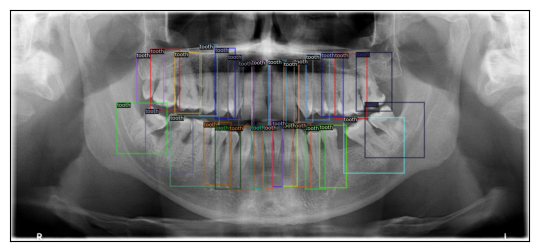

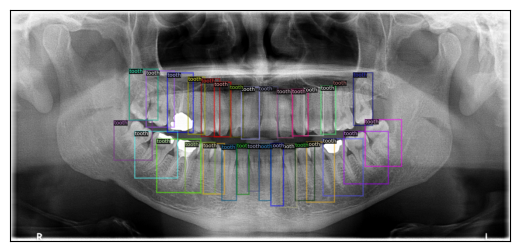

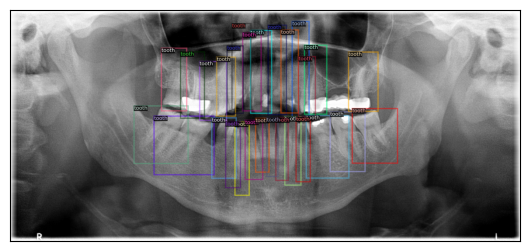

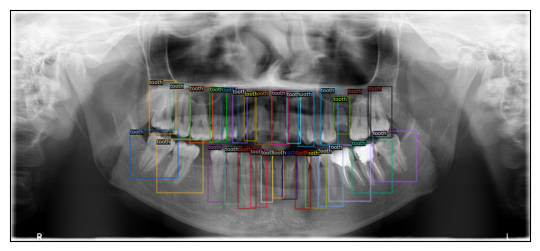

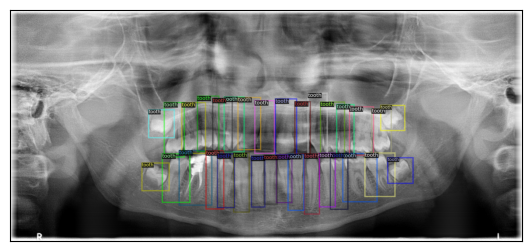

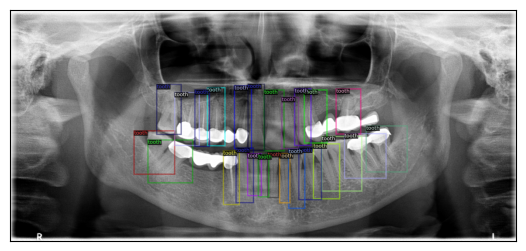

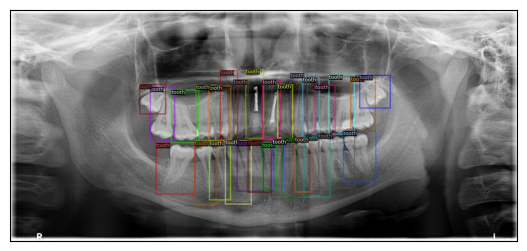

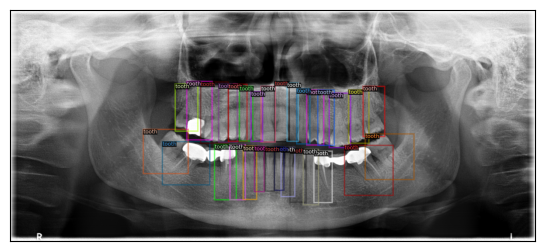

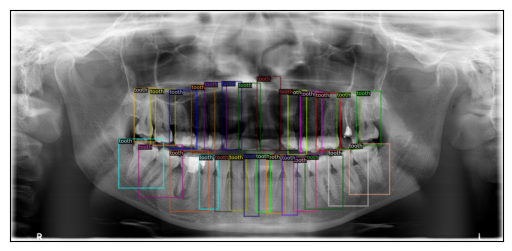

In [11]:
def show_image(image, figsize=(3, 3), title=''):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_title(title)
    ax.set(xticks=[], yticks=[])
    return fig, ax

output_dir = os.path.join(data_dir, 'output')
Path(output_dir).mkdir(exist_ok=True, parents=True)

# Load one image from each data set
n_images_per_dataset = 3
for dataset in dataset_list:
    for example_idx in range(n_images_per_dataset):
        an_dict = DatasetCatalog.get(dataset)[example_idx]
        metadata = MetadataCatalog.get(dataset)
        file = an_dict.get('file_name')
        file_name = os.path.basename(file)
        im = ImageData().load_image(file)
        vs = Visualizer(img_rgb=im, metadata=metadata, scale = 1.0)
        vs = vs.draw_dataset_dict(an_dict).get_image()
        fig, ax = show_image(vs, figsize=(9, 3))
        image_name = f'{os.path.splitext(file_name)[0]}_boxes.png'
        plt.savefig(os.path.join(output_dir, image_name), bbox_inches='tight')
        
        plt.show()